### Topex/Poseidon Level_2 Geophysical Data Record Version F Product Processing

This part is about reading, retrieving and plotting Topex/Poseidon Level 2 Geophysical Data Record (GDR) Version F product in specific study area and its narrow application in inland water level estimation (Here, we choose to estimate water level of lakes situated in High Mountain Asia as an example). More details about GDR version F products and downloadable links it provided can be seen from this website: https://podaac.jpl.nasa.gov/TOPEX-POSEIDON?tab=mission-objectives&sections=about%2Bdata%2Bnews%2Bresources.

In [1]:
## Import some necessary python packages
import os
from glob import *
import json
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
import pygeodesy.geoids as geoids
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.io as io
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

In [2]:
## Read GDR product ".nc" file
tpGdr = "E:/GL/South_Lhonak/Topex_Poseidon/cycle_242/TP_GPN_2PfP242_003_19990409_213505_19990409_223117.nc"
egmPath = "D:/datumConv/egm2008_1/geoids/egm2008-1.pgm"
hmaPath = "D:/SWOT/HMA_region/extents/HMA/gtng_202307_hma_subregions.gpkg"

def topex_poseidon_read(ncPath: str, field: list) -> dict:
    ''' 
    Retrieve one or multiple fields in Topex/Poseidon Level 2 GDR product

    @params:
    ncPath: input GDR file with ".nc" extension
    field: field name with string format in nc file for info retrieval

    return: dictionary contains field info
    '''

    if not os.path.exists(ncPath):
        raise FileNotFoundError(ncPath, "does not exist.")
    if len(field) == 0:
        raise ValueError(field, "is empty.")
    
    fieldList = list(nc.Dataset(ncPath).variables.keys())
    
    result = {}
    if len(field) == 1:
        if not any(field[0] == fldElem for fldElem in fieldList):
            raise ValueError("'" + field[0] + "'" + " field is not listed in " + ncPath)
        
        with nc.Dataset(ncPath, 'r') as ds:
            if any('scale_factor' == attr for attr in ds['/' + field[0]].__dict__.keys()):
                result[field[0]] = ds['/' + field[0]][:].data * np.float64(ds['/' + field[0]].__dict__['scale_factor'])
            else:
                result[field[0]] = ds['/' + field[0]][:].data
    else:
        with nc.Dataset(ncPath, 'r') as ds:
            for elem in field:
                if not any(elem == fldElem for fldElem in fieldList):
                    raise ValueError("'" + elem + "'" + " field is not listed in " + ncPath)
                if any('scale_factor' == attr for attr in ds['/' + elem].__dict__.keys()):
                    result[elem] = ds.variables[elem][:].data
                else:
                    result[elem] = ds.variables[elem][:].data

    return result

field_names = ['time_20hz', 'latitude_20hz', 'longitude_20hz', 'altitude_20hz', 'range_20hz_ku', 'range_used_20hz_ku', 'sig0_20hz_ku', 'sig0_used_20hz_ku', \
               'off_nadir_angle_wf_20hz_ku', 'off_nadir_angle_wf_used_20hz_ku', 'rad_wet_tropo_cor', 'model_wet_tropo_cor_zero_altitude', 'composite_wet_tropo_gpd', \
               'model_dry_tropo_cor_measurement_altitude', 'iono_cor_alt_ku', 'iono_cor_gim_ku', 'mqe_20hz_ku']
fldDict = topex_poseidon_read(ncPath = tpGdr, field = field_names)
fldDict

{'time_20hz': array([[-22991094.54935584, -22991094.49507217, -22991094.4407885 , ...,
         -22991093.62653352, -22991093.57224986, -22991093.5179662 ],
        [-22991093.46366574, -22991093.40938208, -22991093.35509842, ...,
         -22991092.54084358, -22991092.48655993, -22991092.43227628],
        [-22991092.37797666, -22991092.32369301, -22991092.26940936, ...,
         -22991091.45515468, -22991091.40087103, -22991091.34658739],
        ...,
        [-22987725.5473059 , -22987725.493107  , -22987725.43890804, ...,
         -22987724.6259213 , -22987724.57172308, -22987724.51752509],
        [-22987724.4633413 , -22987724.40914657, -22987724.35495834, ...,
         -22987723.54236051, -22987723.48818822, -22987723.43401602],
        [-22987723.37978244, -22987723.32561049, -22987723.27143848, ...,
         -22987722.45886132, -22987722.40468938, -22987722.35051747]]),
 'latitude_20hz': array([[-66.145042, -66.145038, -66.145034, ..., -66.14494 , -66.144931,
         -66.1449

After we have integrated all info we want as a dictionary, we convert dictionary results into dataframe for easy usage.

In [3]:
## Next, we manipulate and clean fldDict
# Convert dict to dataframe for more efficient and simple usage
timeStart = np.datetime64('2000-01-01T00:00:00.000000')  # the start time is derived from "time_20hz" variable
fldDict['time_20hz'] = (timeStart + np.timedelta64(1, 's') * fldDict['time_20hz']).astype(str)  # convert seconds to readable time format
fldDict['rad_wet_tropo_cor'] = np.tile(np.expand_dims(fldDict['rad_wet_tropo_cor'], axis = 1), 20)
fldDict['model_wet_tropo_cor_zero_altitude'] = np.tile(np.expand_dims(fldDict['model_wet_tropo_cor_zero_altitude'], axis = 1), 20)
fldDict['composite_wet_tropo_gpd'] = np.tile(np.expand_dims(fldDict['composite_wet_tropo_gpd'], axis = 1), 20)
fldDict['model_dry_tropo_cor_measurement_altitude'] = np.tile(np.expand_dims(fldDict['model_dry_tropo_cor_measurement_altitude'], axis = 1), 20)
fldDict['iono_cor_alt_ku'] = np.tile(np.expand_dims(fldDict['iono_cor_alt_ku'], axis = 1), 20)
fldDict['iono_cor_gim_ku'] = np.tile(np.expand_dims(fldDict['iono_cor_gim_ku'], axis = 1), 20)

for key in fldDict:
    fldDict[key] = fldDict[key].reshape(-1)

fldDf = pd.DataFrame.from_dict(data = fldDict)
fldDf

,time_20hz,latitude_20hz,longitude_20hz,altitude_20hz,range_20hz_ku,range_used_20hz_ku,sig0_20hz_ku,sig0_used_20hz_ku,off_nadir_angle_wf_20hz_ku,off_nadir_angle_wf_used_20hz_ku,rad_wet_tropo_cor,model_wet_tropo_cor_zero_altitude,composite_wet_tropo_gpd,model_dry_tropo_cor_measurement_altitude,iono_cor_alt_ku,iono_cor_gim_ku,mqe_20hz_ku
0,1999-04-09T21:35:06.000000,-66.145042,348.730107,1.356158e+06,1.356154e+06,0,12.30,0,0.0134,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.9793
1,1999-04-09T21:35:06.000000,-66.145038,348.737006,1.356158e+06,1.356155e+06,0,12.37,0,0.0147,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,1.2138
2,1999-04-09T21:35:06.000000,-66.145034,348.743905,1.356158e+06,1.356155e+06,0,12.37,0,0.0147,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,1.2138
3,1999-04-09T21:35:06.000000,-66.145030,348.750804,1.356158e+06,1.356154e+06,0,12.28,0,0.0118,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.8709
4,1999-04-09T21:35:06.000000,-66.145026,348.757703,1.356158e+06,1.356154e+06,0,12.28,0,0.0118,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.8709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60295,1999-04-09T22:31:18.000000,66.145177,154.454607,1.354210e+06,2.147484e+09,1,32767.00,1,0.0000,1,-0.0251,-0.0159,32767.000,-2.2159,32767.0000,-0.0513,0.0000
60296,1999-04-09T22:31:18.000000,66.145179,154.461495,1.354210e+06,2.147484e+09,1,32767.00,1,0.0000,1,-0.0251,-0.0159,32767.000,-2.2159,32767.0000,-0.0513,0.0000
60297,1999-04-09T22:31:18.000000,66.145180,154.468384,1.354210e+06,2.147484e+09,1,32767.00,1,0.0000,1,-0.0251,-0.0159,32767.000,-2.2159,32767.0000,-0.0513,0.0000
60298,1999-04-09T22:31:18.000000,66.145181,154.475272,1.354210e+06,2.147484e+09,1,32767.00,1,0.0000,1,-0.0251,-0.0159,32767.000,-2.2159,32767.0000,-0.0513,0.0000


We can see that the row count we have retrieved is 60300, which means there are 60300 footprints in a map, but we still notice that not all of them is valid. Since our main goal is to estimate water level, we can roughly filter footprints by "altitude"("altitude_20hz") and "range" ("range_20hz_ku") variable with invalid value inbuilt in this dataset.

In [4]:
# Find FillValue in range and altitude field
with nc.Dataset(tpGdr, 'r') as ds:
    rangeFillValue = np.float64(ds['/range_20hz_ku'].__dict__['_FillValue'])
    altFillValue = np.float64(ds['/altitude_20hz'].__dict__['_FillValue'])

# Drop invalid rows
idxDrop = fldDf[(fldDf['range_20hz_ku'] == rangeFillValue) | (fldDf['altitude_20hz'] == altFillValue)].index
fldDf.drop(idxDrop, inplace = True)
fldDf

,time_20hz,latitude_20hz,longitude_20hz,altitude_20hz,range_20hz_ku,range_used_20hz_ku,sig0_20hz_ku,sig0_used_20hz_ku,off_nadir_angle_wf_20hz_ku,off_nadir_angle_wf_used_20hz_ku,rad_wet_tropo_cor,model_wet_tropo_cor_zero_altitude,composite_wet_tropo_gpd,model_dry_tropo_cor_measurement_altitude,iono_cor_alt_ku,iono_cor_gim_ku,mqe_20hz_ku
0,1999-04-09T21:35:06.000000,-66.145042,348.730107,1.356158e+06,1.356154e+06,0,12.30,0,0.0134,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.9793
1,1999-04-09T21:35:06.000000,-66.145038,348.737006,1.356158e+06,1.356155e+06,0,12.37,0,0.0147,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,1.2138
2,1999-04-09T21:35:06.000000,-66.145034,348.743905,1.356158e+06,1.356155e+06,0,12.37,0,0.0147,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,1.2138
3,1999-04-09T21:35:06.000000,-66.145030,348.750804,1.356158e+06,1.356154e+06,0,12.28,0,0.0118,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.8709
4,1999-04-09T21:35:06.000000,-66.145026,348.757703,1.356158e+06,1.356154e+06,0,12.28,0,0.0118,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.8709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60024,1999-04-09T22:31:03.000000,66.132717,152.587613,1.354204e+06,1.354129e+06,0,32767.00,1,-0.3112,0,-0.0252,-0.0162,32767.000,-2.2635,32767.0000,-0.0507,1.4197
60025,1999-04-09T22:31:03.000000,66.132807,152.594499,1.354204e+06,1.354130e+06,0,32767.00,1,-0.3586,0,-0.0252,-0.0162,32767.000,-2.2635,32767.0000,-0.0507,1.3157
60026,1999-04-09T22:31:03.000000,66.132897,152.601384,1.354204e+06,1.354129e+06,1,32767.00,1,-0.3586,0,-0.0252,-0.0162,32767.000,-2.2635,32767.0000,-0.0507,1.3157
60031,1999-04-09T22:31:04.000000,66.133341,152.635812,1.354204e+06,1.354128e+06,1,32767.00,1,-0.4695,0,-0.0252,-0.0162,32767.000,-2.2635,32767.0000,-0.0507,2.4303


We can see that our dataframe has been squeezed to 36715 rows, meaning there are 23585 rows (about 39.11%) are invalid. Now we still have another trip we need to tackle with...

In [5]:
fldDf['longitude_20hz'].min(), fldDf['longitude_20hz'].max()

(0.0026739999999999997, 359.996021)

We notice that longitude range in this dataset is not in the normal range (-180, 180] (More details expressed in this website: https://www.britannica.com/science/latitude), so we need to normalize meridian range.

In [6]:
fldDf.loc[fldDf['longitude_20hz'] > 180, 'longitude_20hz'] = fldDf[fldDf['longitude_20hz'] > 180]['longitude_20hz'] - 360
fldDf['longitude_20hz'].min(), fldDf['longitude_20hz'].max()

(-11.269893000000025, 152.642698)

Now, we can see that meridian range has been standardized and we can truly start our water level estimation journey. However, before showing code, we utilized two figures here for better illumination.

![alt text](./altitude_range_fig.png)
                                                        
Credits Topex/Poseidon GDR F version product handbook downloaded from this website: https://podaac.jpl.nasa.gov/dataset/TOPEX_POSEIDON_GDR_F

![alt text](./radar_altimetry_corrections.png)                                              
Credits Radar Altimetry Tutorial downloaded from https://www.altimetry.info/articles/radar-altimetry-tutorial/

Now we are clear that the "height" is what we want and it can be roughly computed by subtracting "range" from "altitude". As we have said, the result we acquired is just gross height (More specifically, it is distance from ellipsoidal reference which in our case it is WGS84 reference system, not mean sea level), we still need to carry out geoid height correction and take various radar echoes and instrumental corrections (which has been built in retrieved results), such as geophysical corrections, propagation corrections, and surface corrections, etc for academic usage. However, in this tutorial, we just demonstrate geoid height correction, NOT APPLY radar echoes correction for simplicity.

In [7]:
## Convert WGS84-ellipsoidal height to orthometric height
egm2008 = geoids.GeoidKarney(egmPath)
geoidHgt = egm2008.height(lats = fldDf['latitude_20hz'], lons = fldDf['longitude_20hz'])
np.min(geoidHgt), np.mean(geoidHgt), np.max(geoidHgt)

(-99.83777334688244, -7.441827097398915, 51.77096534647037)

As we can see, the difference between "Orthometric Height" and "Ellipsoidal Height" can be up to ca. 100 m absolutely! After that we start to calculate the gross height measured from mean sea level based on it.

In [8]:
orthoHgt = fldDf['altitude_20hz'] - fldDf['range_20hz_ku'] - geoidHgt
fldDf.insert(loc = fldDf.shape[1], column = 'OrthoHgt', value = orthoHgt)
fldDf

,time_20hz,latitude_20hz,longitude_20hz,altitude_20hz,range_20hz_ku,range_used_20hz_ku,sig0_20hz_ku,sig0_used_20hz_ku,off_nadir_angle_wf_20hz_ku,off_nadir_angle_wf_used_20hz_ku,rad_wet_tropo_cor,model_wet_tropo_cor_zero_altitude,composite_wet_tropo_gpd,model_dry_tropo_cor_measurement_altitude,iono_cor_alt_ku,iono_cor_gim_ku,mqe_20hz_ku,OrthoHgt
0,1999-04-09T21:35:06.000000,-66.145042,-11.269893,1.356158e+06,1.356154e+06,0,12.30,0,0.0134,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.9793,-4.076716
1,1999-04-09T21:35:06.000000,-66.145038,-11.262994,1.356158e+06,1.356155e+06,0,12.37,0,0.0147,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,1.2138,-4.151507
2,1999-04-09T21:35:06.000000,-66.145034,-11.256095,1.356158e+06,1.356155e+06,0,12.37,0,0.0147,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,1.2138,-4.149856
3,1999-04-09T21:35:06.000000,-66.145030,-11.249196,1.356158e+06,1.356154e+06,0,12.28,0,0.0118,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.8709,-4.037764
4,1999-04-09T21:35:06.000000,-66.145026,-11.242297,1.356158e+06,1.356154e+06,0,12.28,0,0.0118,0,-0.0377,-0.0322,-0.035,-2.2560,-0.0171,-0.0167,0.8709,-4.049708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60024,1999-04-09T22:31:03.000000,66.132717,152.587613,1.354204e+06,1.354129e+06,0,32767.00,1,-0.3112,0,-0.0252,-0.0162,32767.000,-2.2635,32767.0000,-0.0507,1.4197,67.862997
60025,1999-04-09T22:31:03.000000,66.132807,152.594499,1.354204e+06,1.354130e+06,0,32767.00,1,-0.3586,0,-0.0252,-0.0162,32767.000,-2.2635,32767.0000,-0.0507,1.3157,67.356945
60026,1999-04-09T22:31:03.000000,66.132897,152.601384,1.354204e+06,1.354129e+06,1,32767.00,1,-0.3586,0,-0.0252,-0.0162,32767.000,-2.2635,32767.0000,-0.0507,1.3157,68.354132
60031,1999-04-09T22:31:04.000000,66.133341,152.635812,1.354204e+06,1.354128e+06,1,32767.00,1,-0.4695,0,-0.0252,-0.0162,32767.000,-2.2635,32767.0000,-0.0507,2.4303,69.642742


We have inserted one column named "OrthoHgt", which is definitely "Orthometric Height" calculated with "EGM2008" model. More details about "EGM2008" model can be seen from Pavlis N K, Holmes S A, Kenyon S C, et al. The development and evaluation of the Earth Gravitational Model 2008 (EGM2008)[J]. Journal of Geophysical Research: Solid Earth, 2012, 117(B4). Next, we want to see where our dataset located.

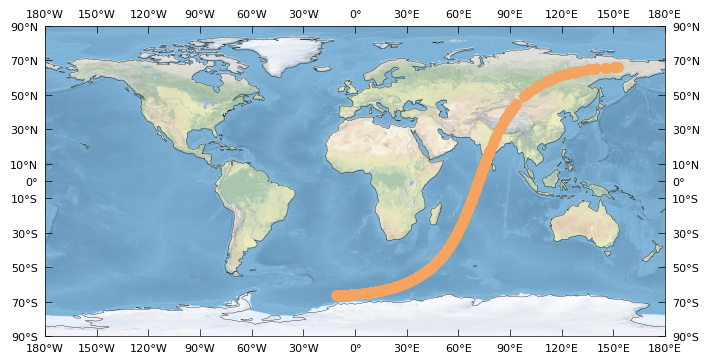

In [9]:
fig = plt.figure(figsize = (8, 6))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection = crs)
ax.plot(fldDf['longitude_20hz'], fldDf['latitude_20hz'], 'o', color = 'sandybrown', markersize = 6)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.set_xticks([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
ax.set_yticks([-90, -70, -50, -30, -10, 0, 10, 30, 50, 70, 90])
ax.tick_params(axis = 'both', which = 'major', labelsize = 8, direction = 'in', length = 5, width = 0.5, pad = 5, top = True, right = True, labeltop = True, labelright = True)
ax.spines['geo'].set_linewidth(0.5)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, lw = 0.25)
ax.add_feature(cfeature.RIVERS, lw = 0.25)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.OCEAN)
ax.stock_img()

ax.set_extent((-180, 180, -90, 90), crs)
plt.show()

It is pretty explicit that our retrieved dataset is between -30 and 150 in longitude ,and -70 and 70 in latitude. Since our specific study area is High Mountain Asia, we want to see footprints distribution within it in detail.

C:\Users\60202\AppData\Local\Temp\ipykernel_7724\302995233.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax.text(hmaGdf.centroid.x.tolist()[i] - 3, hmaGdf.centroid.y.tolist()[i], hmaGdf['full_name'][i], transform = crs, color = 'black', fontsize = 8, alpha = 0.8)


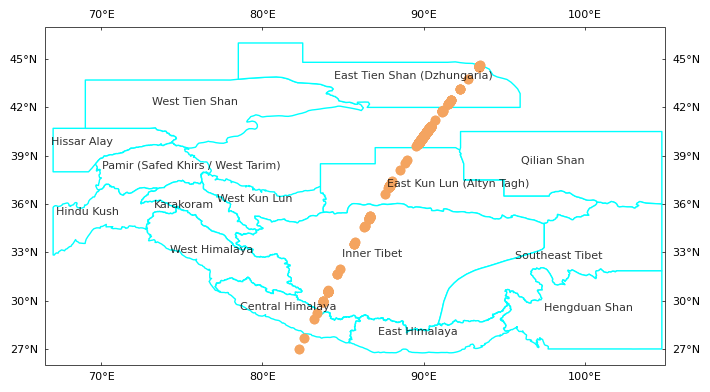

In [10]:
hmaGdf = gpd.read_file(hmaPath)

fig = plt.figure(figsize = (8, 6))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection = crs)
ax.add_geometries(hmaGdf['geometry'], crs = crs, facecolor = 'white', edgecolor = 'cyan')
for i in range(hmaGdf.shape[0]):
    ax.text(hmaGdf.centroid.x.tolist()[i] - 3, hmaGdf.centroid.y.tolist()[i], hmaGdf['full_name'][i], transform = crs, color = 'black', fontsize = 8, alpha = 0.8)
ax.plot(fldDf['longitude_20hz'], fldDf['latitude_20hz'], 'o', color = 'sandybrown', markersize = 6)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.set_xticks([70, 80, 90, 100])
ax.set_yticks([27, 30, 33, 36, 39, 42, 45])
ax.tick_params(axis = 'both', which = 'major', labelsize = 8, direction = 'in', length = 2, width = 0.5, pad = 5, top = True, right = True, labeltop = True, labelright = True)
ax.spines['geo'].set_linewidth(0.5)

ax.set_extent((66.5, 105, 26, 47), crs)
plt.show()

This figure displays that footprints intersects with East Tien Shan, East Kun Lun, Inner Tibet, and Central Himalaya region. But whether footprints crosses the lakes? If it does, where is it? Before answering our question, we need to convert dataframe into geojson and show them in Google Earth to make it clear.

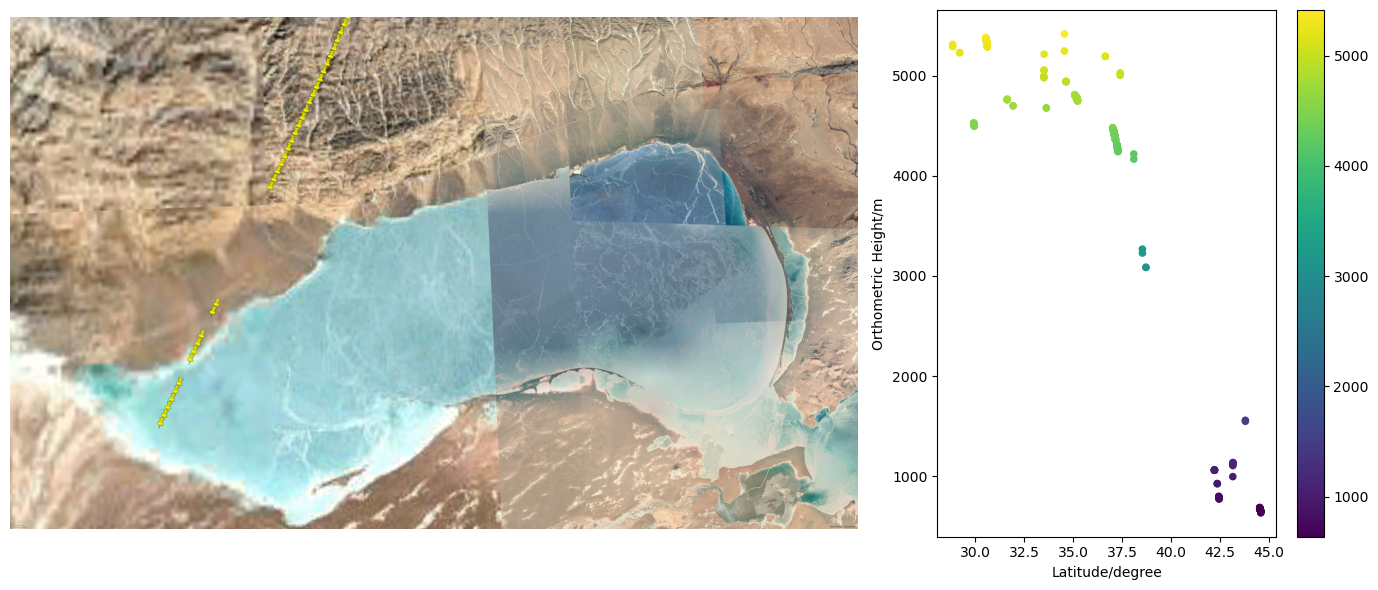

In [12]:
## Convert dataframe to geodataframe
fldGdf = gpd.GeoDataFrame(fldDf, geometry = gpd.points_from_xy(fldDf['longitude_20hz'], fldDf['latitude_20hz']), crs = "EPSG:4326")
fldGdfClip = fldGdf.clip(hmaGdf.geometry)
fldGdfClip.to_file(filename = "D:/Downloads/TP_GPN_2PfP242_003_19990409_213505_19990409_223117.geojson", driver = 'GeoJSON')

ptsLakePath = "D:/Downloads/Fig1_footprints_in_lake_Google_Earth.jpg"
ptsLakeArr = cv2.imread(ptsLakePath, cv2.IMREAD_COLOR)[:, :, ::-1]

fig = plt.figure(figsize = (14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 0.5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.axis('off')
axPlot1 = ax1.imshow(ptsLakeArr)
axPlot2 = ax2.scatter(fldGdfClip['latitude_20hz'], fldGdfClip['OrthoHgt'], c = fldGdfClip['OrthoHgt'], s = 20, marker = 'o', cmap = 'viridis')
ax2.set_xlabel(xlabel = "Latitude/degree")
ax2.set_ylabel(ylabel = "Orthometric Height/m")
plt.colorbar(axPlot2, ax = ax2)
plt.tight_layout()
plt.show()

After we have transfer our dataset into geojson format and display it in Google Earth, we can see that there are indeed some footprints (More specifically, 8 footprints) located in the lake! (See left figure). And we also plot "Orthometric Height" variations of all footprints corresponding with latitude range (See right figure). I think it is time for us to see how orthometric height of footprints varies directly located within this lake!

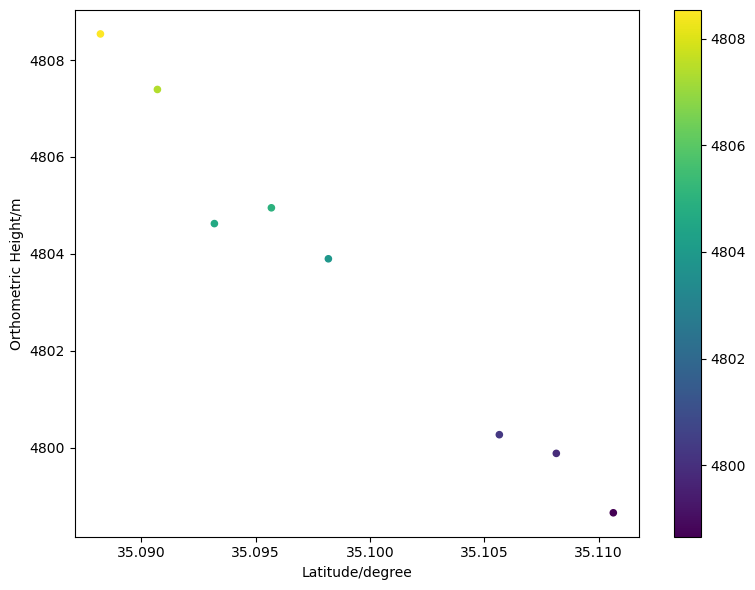

(4798.659908406297, 4803.527811038275, 4808.537711081006)

In [13]:
lakeFpsStack = fldGdfClip.iloc[[69, 70, 71, 72, 73, 74, 75, 76]]

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)
axPlot = ax.scatter(lakeFpsStack['latitude_20hz'], lakeFpsStack['OrthoHgt'], c = lakeFpsStack['OrthoHgt'], s = 20, marker = 'o', cmap = 'viridis')
ax.set_xlabel(xlabel = "Latitude/degree")
ax.set_ylabel(ylabel = "Orthometric Height/m")
plt.colorbar(axPlot, ax = ax)
plt.tight_layout()
plt.show()
lakeFpsStack['OrthoHgt'].min(), lakeFpsStack['OrthoHgt'].mean(), lakeFpsStack['OrthoHgt'].max()

At this step, we are fairly clear about the orthometric height variations derived from Topex/Poseidon satellite altimeter footprints. The result shows water level of this lake ranging from 4798.66 m a.s.l. to 4808.54 m a.s.l. in the period 1999-04-09 22:15:19. Finally, the last step is to validate this result with other measurements. Due to the absence of in-situ water level gauge of this lake, we choose ICESat-2 laser altimeter measurement as validation. Although the time period of ICESat-2 operational period is commencing from 2018-10-13, which is different from our period, we just take ICESat-2 ATL08 (Land and Vegetation Height Version 006) product as illustration in this tutorial, NOT FOR PUBLICATION usage.

### Lake Level Accuracy Validation

for simplicity, ICESat-2 ATL08 version 006 product downloading and processing is not in the domain of this tutorial, we only use its result to compare with ours.

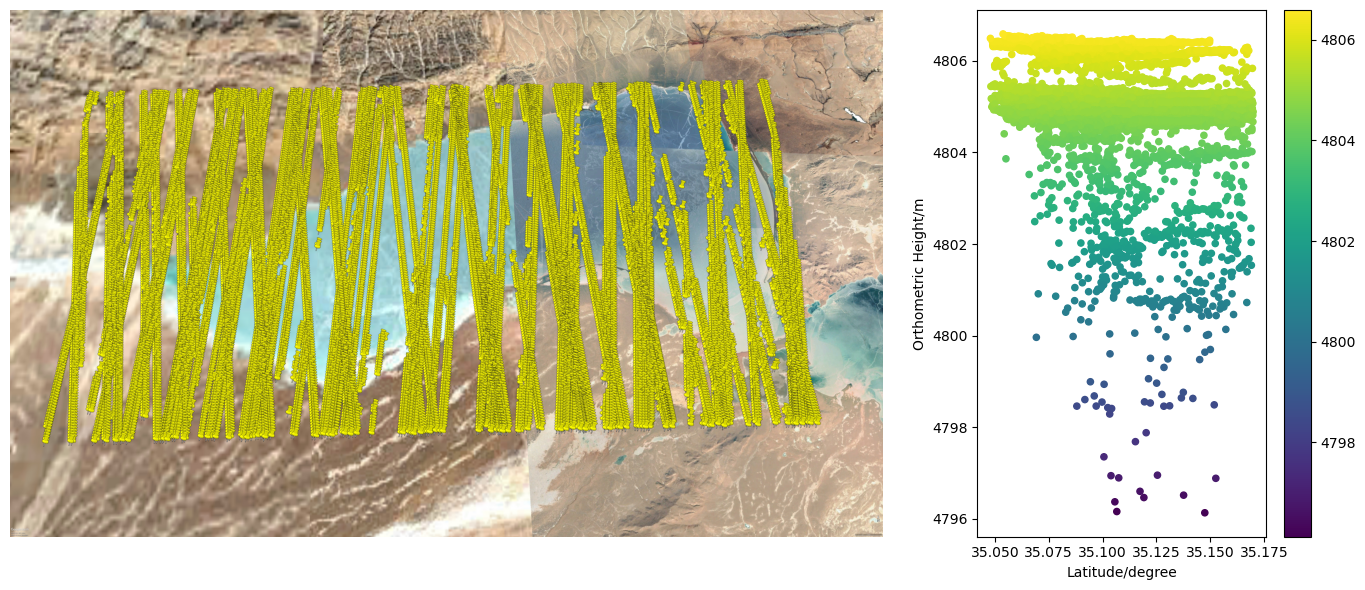

In [14]:
ptsLakePath = "D:/Downloads/Fig2_ATL08_footprints_in_lake_Google_Earth.jpg"
ATL08Path = "D:/Downloads/ATL08_footprints.geojson"
ptsLakeArr = cv2.imread(ptsLakePath, cv2.IMREAD_COLOR)[:, :, ::-1]
atl08Gdf = gpd.read_file(ATL08Path)
atl08Gdf['ElevEGM2008'] = atl08Gdf['ElevEGM2008'].astype(np.float64)

fig = plt.figure(figsize = (14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 0.4])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.axis('off')
axPlot1 = ax1.imshow(ptsLakeArr)
axPlot2 = ax2.scatter(atl08Gdf['Latitude'], atl08Gdf['ElevEGM2008'], c = atl08Gdf['ElevEGM2008'], s = 20, marker = 'o', cmap = 'viridis')
ax2.set_xlabel(xlabel = "Latitude/degree")
ax2.set_ylabel(ylabel = "Orthometric Height/m")
plt.colorbar(axPlot2, ax = ax2)
plt.tight_layout()
plt.show()

So based on this figure, there are 8426 footprints located within this lake (left figure is for exhibition, its footprint number is more than that). Take a peek at right figure, which uses 8426 footprints during 2018-2024 and it demonstrates the minimum averaged water level is 4796.13 m a.s.l., mean averaged water level is 4804.97 m a.s.l., and the maximum averaged water level is 4806.59 m a.s.l., which is very close to our gross orthometric height result, despite that water level fluctuates from 1999 to 2018-2024 and deviate monthly.

### Conclusion

This tutorial states that Topex/Poseidon GDR Version F product can be used to monitor inland water level variations. Water level derived from this dataset shows that its mean value is 4803.53 m a.s.l.. For validation, we use ICESat-2 ATL08 Version 006 product to estimate water level during 2018-2024 and it shows the mean averaged water level of this lake is 4804.97 m a.s.l., which is in close with our retrieved result, albeit without radar echoes corrections.
To conclude, aside from Topex/Poseidon GDR Version F product retrieval and processing, this tutorial also demonstrates the accuracy and application of radar altimetry in inland water level investigation.